In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import mido
import numpy as np
from PIL import Image, ImageDraw


In [5]:


def midi_to_image(midi_file, bpm=None, ticks_per_beat=16, duration=None):
    # Parse MIDI file
    mid = mido.MidiFile(midi_file)
    if ticks_per_beat is None:
        ticks_per_beat = mid.ticks_per_beat

    bpm = bpm or 120  # Default to 120 BPM
    sec_per_tick = 60 / (bpm * ticks_per_beat)
    
    # Calculate total time and initialize piano roll
    total_time = sum(msg.time for msg in mid)
    
    max_time = int(total_time / sec_per_tick)
    if duration is None:
        piano_roll = np.zeros((88, (max_time + 1)), dtype=np.uint8)
    else:
        piano_roll = np.zeros((88, int(duration / sec_per_tick)+1), dtype=np.uint8)
    
    # Track active notes
    active_notes = {}

    # Iterate over MIDI messages
    time = 0
    for msg in mid:
        time += msg.time / sec_per_tick  # Time in seconds
        
        if msg.type == 'note_on' and msg.velocity > 0:  # Note starts
            key = msg.note - 21
            if 0 <= key < 88:
                active_notes[key] = time  # Record when the note starts
        
        elif msg.type in ['note_off', 'note_on'] and msg.velocity == 0:  # Note ends
            key = msg.note - 21
            if key in active_notes:
                start_time = active_notes.pop(key)
                start_pixel = int(start_time)
                end_pixel = int(time)
                
                # Fill the range of pixels for the note duration
                if end_pixel >= piano_roll.shape[1]:
                    new_cols = end_pixel - piano_roll.shape[1] + 1
                    piano_roll = np.pad(piano_roll, ((0, 0), (0, new_cols)), mode='constant')
                
                piano_roll[key, start_pixel:end_pixel] = 255
        if duration is not None and time > int(duration / sec_per_tick):
            break
    # Transpose to make it height x width (keys x time)
    piano_roll = piano_roll.T
    # Create image
    img = Image.fromarray(piano_roll, mode='L')
    return img


# Example usage
notes = midi_to_image(
    'simple_piano/Pirates of the Caribbean - Hes a Pirate.mid',
    bpm=120, duration=None
)

In [6]:

def draw_piano(width_white_key=20, width_black_key=15, height=100):
    # Determine the total width of the keyboard (88 keys)
    num_white_keys = 52
    total_width = num_white_keys * width_white_key
    
    # Create the image
    img = Image.new("RGB", (total_width, height), "white")
    draw = ImageDraw.Draw(img)
    
    # Black keys layout for an octave (repeated 7 times + one extra)
    black_key_positions = [1, 2, 4, 5, 6]  # 0-indexed relative to white keys
    
    # Draw white keys
    for i in range(num_white_keys):
        x_start = i * width_white_key
        draw.rectangle([x_start, 0, x_start + width_white_key - 1, height], outline="black", fill="white")
    
    # Draw black keys (shorter and narrower)
    for octave in range(8):  # 7 octaves
        for pos in black_key_positions:
            key_index = octave * 7 + pos - 5
            if key_index >= 88:
                break
            x_start = key_index * width_white_key - width_black_key // 2
            if x_start > 0:
                draw.rectangle([x_start, 0, x_start + width_black_key - 1, height * 0.6], fill="black")
    
    # # Handle the final black keys for the last octave
    # for pos in black_key_positions:
    #     key_index = 7 * 7 + pos
    #     if key_index >= 88:
    #         break
    #     x_start = key_index * width_white_key - width_black_key // 2
    #     draw.rectangle([x_start, 0, x_start + width_black_key - 1, height * 0.6], fill="black")
    
    return img

# Example usage
width_white_key = 13
width_black_key = 8
piano_image = draw_piano(width_white_key=width_white_key, width_black_key=width_black_key, height=50)

piano = np.array(piano_image)[:, :, 0]
piano = np.vstack([piano, np.zeros((30, piano.shape[1]))])
notes = np.array(notes)

In [7]:

wider_notes = np.zeros((notes.shape[0], piano.shape[1]))

n_c = 0
for count in range(52):
    if (count+5)%7 in [0, 1, 3, 4, 5] and ((count+5)+6)%7 not in [0, 1, 3, 4, 5]:
        wider_notes[:, int(count*width_white_key+1) : int(count*width_white_key+1) + 7] = notes[:,[n_c]]
        n_c += 1
        if n_c < 88:
            wider_notes[:, int(count*width_white_key+9) : int(count*width_white_key+9) + 6] = notes[:,[n_c]]
        n_c += 1
    elif (count+5)%7 in [0, 1, 3, 4, 5] and ((count+5)+6)%7 in [0, 1, 3, 4, 5]:
        wider_notes[:, int(count*width_white_key+3) : int(count*width_white_key+3) + 7] = notes[:,[n_c]]
        n_c += 1
        if ((count+5)+1)%7 in [0, 1, 3, 4, 5]:
            wider_notes[:, int(count*width_white_key+11) : int(count*width_white_key+11) + 4] = notes[:,[n_c]]
            n_c += 1
        else:
            wider_notes[:, int(count*width_white_key+11) : int(count*width_white_key+11) + 6] = notes[:,[n_c]]
            n_c += 1
    else:
        wider_notes[:, int(count*width_white_key+5) : int(count*width_white_key+5) + 7] = notes[:,[n_c]]
        n_c += 1
        


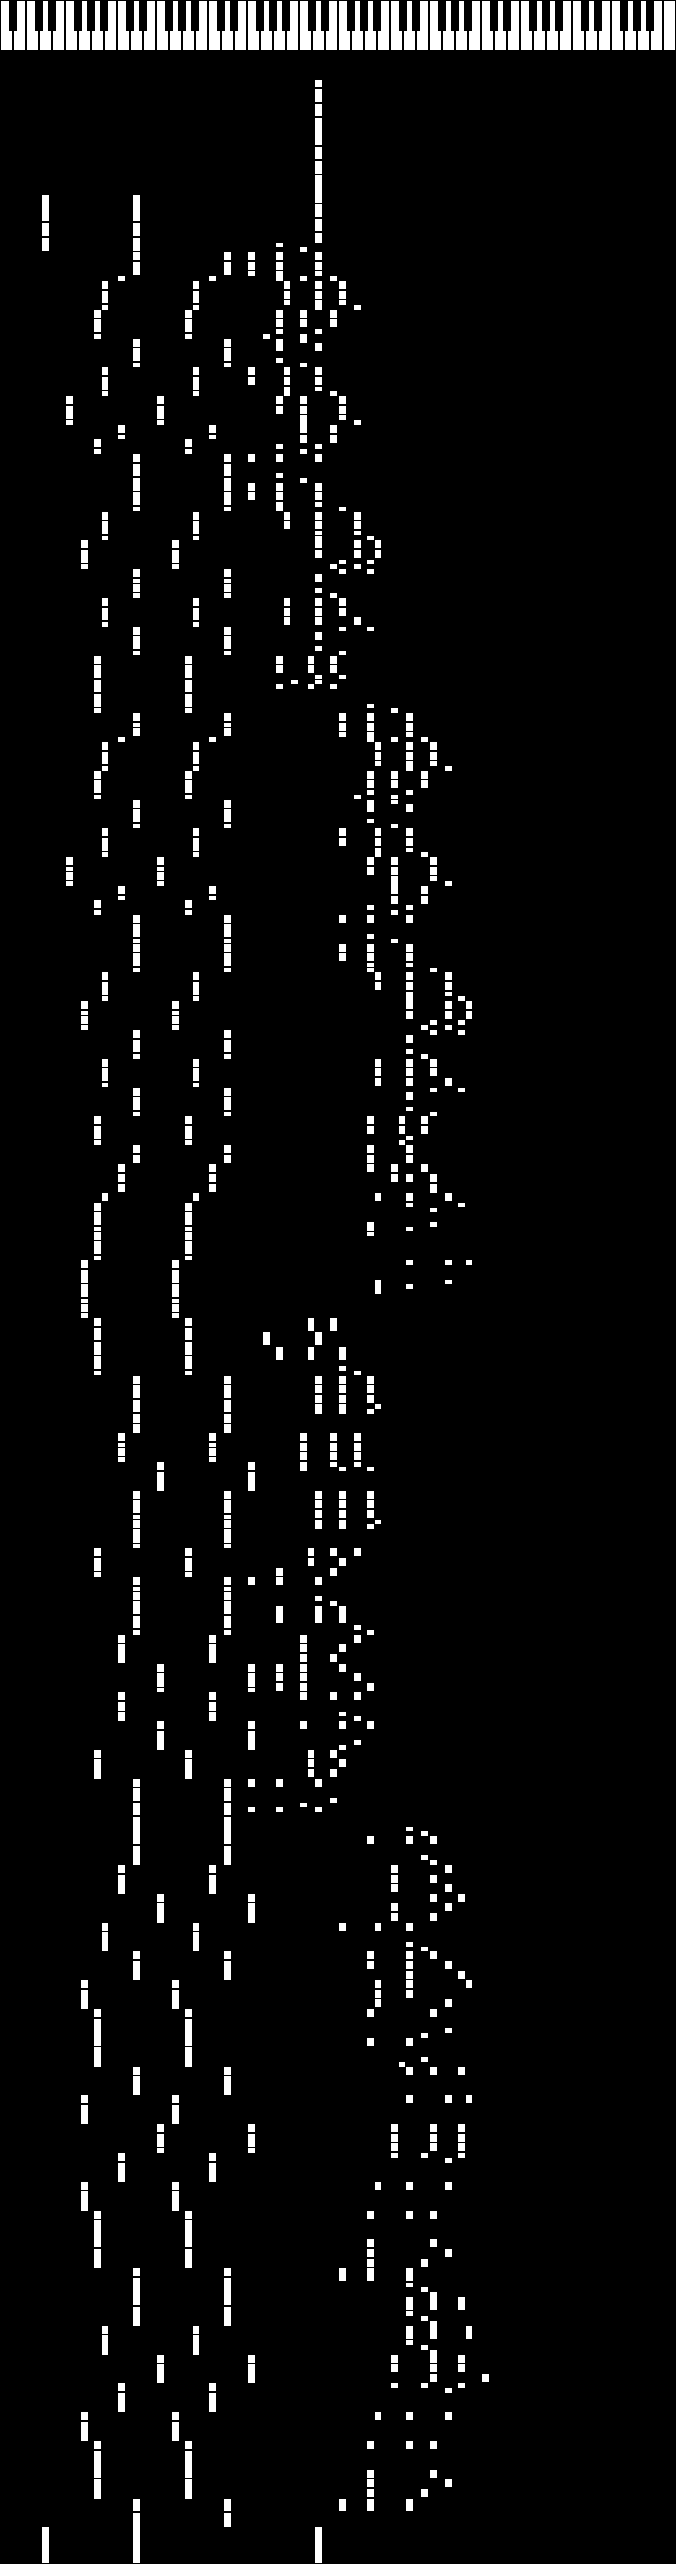

In [12]:
img = Image.fromarray(np.vstack([piano, wider_notes]).astype(np.uint8)[::1], mode="L")
img.save("output.png")
img